Importing Libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.dpi'] = 1000 # Increase image resolution
plt.rcParams['savefig.dpi'] = 1000 # Increase image resolution
#import plotly.express as px
from scipy import optimize
from scipy.optimize import Bounds

Importing, Visualising and Editing Battery Dataframe

In [2]:
df = pd.read_csv('RW3together.csv') # Import Battery Dataset (RW3/RW4/RW5/RW6 = Battery 1/2/3/4 Respectively)
df.comment = pd.Categorical(df.comment) # Conversion to categorical variable

In [3]:
# Creating new dataframe (Section 3.3.1)
time1 = np.zeros(len(df)) # New time variable to perform dt calculations
time1[0] = df.time[0] # Initialising first value
for i in range(1,len(df)):
    time1[i] = df.time[i-1] # Shifting time variable by one value
dt = df.time - time1 # Subtracting the shifted gives the time difference (dt) between every datapoint 
df['dt'] = dt # Forming the new column
df1 = df[['comment','voltage','current','temperature','relativeTime','time','dt']] # Reordering the columns
dq = dt*df1["current"] # Forming a new variable with the charge difference (dq) between every datapoint
df1['dq'] = dq # Forming a new column ...

/var/folders/gj/vbyyhc_x1z199k97d4xd9gy40000gn/T/ipykernel_5027/2140887956.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dq'] = dq # Forming a new column ...


Modelling: Using Reference Paper -> Electrochemistry-based Battery Modeling for Prognostics

In [4]:
#Constant Parameters in the Model:(Section 3.3.2)
start = 22768 # Index at the start of the first pulsed discharge regime
end = 45719 # Index at the end of the first pulsed discharge regime
# Table 3.1
Ap0 = -33642.23 # (J/mol)
Ap1 = 0.11 # (J/mol)
Ap2 = 23506.89 # (J/mol)
Ap3 = -74679.26 # (J/mol)
Ap4 = 14359.34 # (J/mol)
Ap5 = 307849.79 # (J/mol)
Ap6 = 85053.13 # (J/mol)
Ap7 = -1075148.06 # (J/mol)
Ap8 = 2173.62 # (J/mol)
Ap9 = 991586.68 # (J/mol)
Ap10 = 283423.47 # (J/mol)
Ap11 = -163020.34 # (J/mol)
Ap12 = -470297.35 # (J/mol)
Ap = [Ap0, Ap1, Ap2, Ap3, Ap4, Ap5, Ap6, Ap7, Ap8, Ap9, Ap10, Ap11, Ap12] # Forming vector with the simplex coefficients
An0 = 86.19 # (J/mol)
U0p = 4.03 # (V)
U0n = 0.01 # (V)

# Table 3.2
R = 8.314 # (J/mol/K)
T = 292 # (K)
F = 96487 # (C/mol)
n = 1 # (Dimensionless)
D = 7*(10**6) # (mol s/C/m^3)
tau0 = 10 # (s)
taup = 90 # (s)
taun = 90 # (s)
alpha = 0.5 # (Dimensionless)
R0 = 0.085 # (ohm)
QMAX = 1.32*(10**4) # (C)
Sp = 2*(10**-4) # (m^2)
Sn = 2*(10**-4) # (m^2)
kp = 2*(10**4) # (A/m^2)
kn = 2*(10**4) # (A/m^2)
vsp = 2*(10**-6) # (m^3)
vsn = 2*(10**-6) # (m^3)
vbp = 2*(10**-5) # (m^3)
vbn = 2*(10**-5) # (m^3)
vn = vsn + vbn # (m^3) (eq 3.9) 
vp = vsp + vbp # (m^3) (eq 3.9)
act_len = (end-start+1) #(eq 3.41) Length of the total number of datapoints in the pulsed discharge regime

In [5]:
# Section 4.2 - Function used for giving output as MSE (wrt Voltage) for Different Capacity and Internal Resistance values.
def Model(opt):
    # opt is a 2D Vector taking in the Capacity and Internal Resistance as an input
    try:
        # Try introduced to direct the solver towards convergence (check at the bottom)
        QMAX_s = opt[0]
        R0_s = opt[1]
        # Intialisation (Section 3.3.4)
        x_t = np.zeros(act_len)
        xn_t = np.zeros(act_len)
        xp_t = np.zeros(act_len)
        xsp_t = np.zeros(act_len)
        xsn_t = np.zeros(act_len)
        xbp_t = np.zeros(act_len)
        xbn_t = np.zeros(act_len)
        qsp_t = np.zeros(act_len)
        qbp_t = np.zeros(act_len)
        qbn_t = np.zeros(act_len)
        qsn_t = np.zeros(act_len)
        qn_t = np.zeros(act_len)
        qp_t = np.zeros(act_len)
        V0_t = np.zeros(act_len)
        Vetap_t = np.zeros(act_len)
        Vetan_t = np.zeros(act_len)
        Jp0_t = np.zeros(act_len)
        Jn0_t = np.zeros(act_len)
        VUp_t = np.zeros(act_len)
        VUn_t = np.zeros(act_len)
        VUpn_t = np.zeros(act_len)
        VINTn_t = np.zeros(act_len)
        VINTp_t = np.zeros(act_len)
        Vetap_tt = np.zeros(act_len)
        Vetan_tt = np.zeros(act_len)
        V0_tt = np.zeros(act_len)
        V_t = np.zeros(act_len)
        qbsn_tt = np.zeros(act_len)
        qbsp_tt = np.zeros(act_len)
        cbp_t = np.zeros(act_len)
        csp_t = np.zeros(act_len)
        cbn_t = np.zeros(act_len)
        csn_t = np.zeros(act_len)
        
        #Coulomb Counting (Section 3.3.4)
        iapp = np.array(df1.current[start:end+1])
        for i in range(act_len):
            qn_t[i] = QMAX_s*0.6 - np.sum(dq[start:start+i]) # (eq 3.42) At, 100% SOC, Charge in the negative terminal (qn) is 0.6 times the total capacity (0.6*QMAX). Thus, qp = 0.4*QMAX
        
        #Surface/Bulk (Positive/Negative) Distributed Charge Calculations (Section 3.2.2/3.3.4)
        #Initialisation:
        qp_t[0] = QMAX_s-qn_t[0] # eq 3.4
        #Initially cs,i = cb,i
        qbp_t[0] = (10/11)*qp_t[0] # eq 3.7/3.8
        qsp_t[0] = (1/11)*qp_t[0] # eq 3.7/3.8
        qsn_t[0] = (1/11)*qn_t[0] # eq 3.7/3.8
        qbn_t[0] = (10/11)*qn_t[0] # eq 3.7/3.8
        for i in range(1,act_len):
            # Euler Method with timesteps = Change in dataset's time recording (Since, it's a relatively small scale effect)
            qsp_t[i] = qsp_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(iapp[i-1] + (1/D)*(qbp_t[i-1]/vbp - qsp_t[i-1]/vsp)) # eq 3.13
            qbp_t[i] = qbp_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-(1/D)*(qbp_t[i-1]/vbp - qsp_t[i-1]/vsp)) # eq 3.14
            qbn_t[i] = qbn_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-(1/D)*(qbn_t[i-1]/vbn - qsn_t[i-1]/vsn)) # eq 3.15
            qsn_t[i] = qsn_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-iapp[i-1] + (1/D)*(qbn_t[i-1]/vbn - qsn_t[i-1]/vsn)) # eq 3.16
        qp_t=qsp_t+qbp_t # eq 3.10
        qn_t=qsn_t+qbn_t # eq 3.10
        xsn_t = (qsn_t)/((QMAX_s*vsn)/(vn)) # eq 3.18/3.19
        xbn_t = (qbn_t)/((QMAX_s*vbn)/(vn)) # eq 3.18/3.19
        xsp_t = (qsp_t)/((QMAX_s*vsp)/(vp)) # eq 3.18/3.19
        xbp_t = (qbp_t)/((QMAX_s*vbp)/(vp)) # eq 3.18/3.19
        xp_t = (qp_t)/(QMAX_s) # eq 3.4
        xn_t = (qn_t)/(QMAX_s) # eq 3.4  
        
        #V0,VINT and VU negative/postive electrode calculations - TimeSeries (Section 3.2.2/3.2.3/3.3.4)
        for i in range (act_len):
            VINTsum = np.zeros(13)
            # eq 3.6
            for k in range (len(VINTsum)):
                VINTsum[k] = (1/(n*F))*(Ap[k])*((((2*xsp_t[i])-1)**(k+1))-(2*xsp_t[i]*k*(1-xsp_t[i])*(((2*xsp_t[i])-1)**(k-1))))
            VINTn_t[i] = (1/(n*F))*(An0)*(2*xsn_t[i]-1) # eq 3.6
            VINTp_t[i] = np.sum(VINTsum) # eq 3.6
            VUp_t[i] = U0p + ((R*T)/(n*F))*(math.log((1-xsp_t[i])/xsp_t[i])) + VINTp_t[i] # eq 3.17
            VUn_t[i] = U0n + ((R*T)/(n*F))*(math.log((1-xsn_t[i])/xsn_t[i])) + VINTn_t[i] # eq 3.17
            V0_t[i] = iapp[i]*R0_s # eq 3.22
    
        #Veta_p/n calculations - TimeSeries (Section 3.2.4/3.3.4)
        for i in range (act_len):
            Jp0_t[i] = kp*((1-xsp_t[i])**0.5)*((xsp_t[i])**0.5) # eq 3.25
            Jn0_t[i] = kn*((1-xsn_t[i])**0.5)*((xsn_t[i])**0.5) # eq 3.25
            Vetap_t[i] = ((R*T)/(F*0.5))*(np.arcsinh((iapp[i]/Sp)/(2*Jp0_t[i]))) # eq 3.23
            Vetan_t[i] = ((R*T)/(F*0.5))*(np.arcsinh((iapp[i]/Sn)/(2*Jn0_t[i]))) # eq 3.23
    
        #Transient Calculations - Euler Method - Timeseries (Section 3.2.6/3.3.4)
        V0_tt[0] = V0_t[0] # eq 3.31
        Vetap_tt[0] = Vetap_t[0] # eq 3.32
        Vetan_tt[0] = Vetan_t[0] # eq 3.33
        for i in range (1,act_len):
            # Euler Method with timesteps = Change in dataset's time recording (Since, it's a relatively small scale effect)
            V0_tt[i] = V0_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/tau0)*(V0_t[i-1]-V0_tt[i-1])) # eq 3.31
            Vetap_tt[i] = Vetap_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/taup)*(Vetap_t[i-1]-Vetap_tt[i-1])) # eq 3.32
            Vetan_tt[i] = Vetan_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/taun)*(Vetan_t[i-1]-Vetan_tt[i-1])) # eq 3.33
    
        #SOC Calculations (Section 3.2.5/3.3.4)
        SOCn = np.zeros(act_len)
        SOCa = np.zeros(act_len)
        for i in range(act_len):
            SOCn[i] = 100*(qn_t[i]/(0.6*QMAX_s)) # eq 3.26
            SOCa[i] = 100*((qsn_t[i]*vn)/(0.6*QMAX_s*vsn)) # eq 3.27/3.28
            
            #Final Predicted Voltages (Section 3.2.6/3.3.4)
            V_t[i] = VUp_t[i]- VUn_t[i] - V0_tt[i] - Vetap_tt[i] - Vetan_tt[i] # eq 3.30
            
            # Section 4.3 - Clipping at 3.2V (As in the experiment, the cell operates only b/w 4.2 V & 3.2 V)
            if V_t[i]<3.2: 
                V_t[i] = 3.2
                
        #Error Calculations:
        MAE = (np.sum(abs(V_t - np.array(df1.voltage[start:end+1]))))/(act_len)
        MSE = (np.sum(np.multiply((V_t-np.array(df1.voltage[start:end+1])),(V_t-np.array(df1.voltage[start:end+1])))))/(act_len)
        #Choose MAE/MSE Accordingly by changing the return (Paper used MSE)
        return (MSE)
    except ValueError:
        #The try-catch used over here returns NAN values helping redirect the search algorithm towards convergence
        #Furthermore, it eliminates the need to define bounds in such a case
        print("NaN Returned")
        return(np.nan)

In [6]:
#If bounds were being used:
# Constraints-
# 0.6*Qmax - np.sum(dq[start:end+1]) > 0
# R0 > 0
# 12210<Qmax<32000
# 0.01 < R0 < 2

In [7]:
#bounds = Bounds([12500, 0.01],  # [min QMAX, min R0]
                #[24000, 2])  # [max QMAX, max R0]
# Lower Bounds were decided by the above cell and upper Bounds can be varied knowing the paper's range of QMAX/R0  

In [8]:
res = optimize.minimize(Model,[13200,0.085],method='Nelder-Mead')#,bounds=bounds)

NaN Returned


In [9]:
#Section 4.2 - Function used for plotting the Voltage vs Time results for optimised/unoptimised & Dataset values
def Model1(opt):
    #opt is a 2D Vector taking in the Capacity and Internal Resistance as an input
    QMAX_s = opt[0]
    R0_s = opt[1]
    #Intialisation (Section 3.3.4)
    x_t = np.zeros(act_len)
    xn_t = np.zeros(act_len)
    xp_t = np.zeros(act_len)
    xsp_t = np.zeros(act_len)
    xsn_t = np.zeros(act_len)
    xbp_t = np.zeros(act_len)
    xbn_t = np.zeros(act_len)
    qsp_t = np.zeros(act_len)
    qbp_t = np.zeros(act_len)
    qbn_t = np.zeros(act_len)
    qsn_t = np.zeros(act_len)
    qn_t = np.zeros(act_len)
    qp_t = np.zeros(act_len)
    V0_t = np.zeros(act_len)
    Vetap_t = np.zeros(act_len)
    Vetan_t = np.zeros(act_len)
    Jp0_t = np.zeros(act_len)
    Jn0_t = np.zeros(act_len)
    VUp_t = np.zeros(act_len)
    VUn_t = np.zeros(act_len)
    VUpn_t = np.zeros(act_len)
    VINTn_t = np.zeros(act_len)
    VINTp_t = np.zeros(act_len)
    Vetap_tt = np.zeros(act_len)
    Vetan_tt = np.zeros(act_len)
    V0_tt = np.zeros(act_len)
    V_t = np.zeros(act_len)
    qbsn_tt = np.zeros(act_len)
    qbsp_tt = np.zeros(act_len)
    cbp_t = np.zeros(act_len)
    csp_t = np.zeros(act_len)
    cbn_t = np.zeros(act_len)
    csn_t = np.zeros(act_len)
    
    #Coulomb Counting (Section 3.3.4)
    iapp = np.array(df1.current[start:end+1])
    for i in range(act_len):
        qn_t[i] = QMAX_s*0.6 - np.sum(dq[start:start+i]) # (eq 3.42) At, 100% SOC, Charge in the negative terminal (qn) is 0.6 times the total capacity (0.6*QMAX). Thus, qp = 0.4*QMAX
    
    #Surface/Bulk (Positive/Negative) Distributed Charge Calculations (Section 3.2.2/3.3.4)
    #Initialisation:
    qp_t[0] = QMAX_s-qn_t[0] # eq 3.4
    #Initially cs,i = cb,i
    qbp_t[0] = (10/11)*qp_t[0] # eq 3.7/3.8
    qsp_t[0] = (1/11)*qp_t[0] # eq 3.7/3.8
    qsn_t[0] = (1/11)*qn_t[0] # eq 3.7/3.8
    qbn_t[0] = (10/11)*qn_t[0] # eq 3.7/3.8

    for i in range(1,act_len):
        # Euler Method with timesteps = Change in dataset's time recording (Since, it's a relatively small scale effect)
        qsp_t[i] = qsp_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(iapp[i-1] + (1/D)*(qbp_t[i-1]/vbp - qsp_t[i-1]/vsp)) # eq 3.13
        qbp_t[i] = qbp_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-(1/D)*(qbp_t[i-1]/vbp - qsp_t[i-1]/vsp)) # eq 3.14
        qbn_t[i] = qbn_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-(1/D)*(qbn_t[i-1]/vbn - qsn_t[i-1]/vsn)) # eq 3.15
        qsn_t[i] = qsn_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-iapp[i-1] + (1/D)*(qbn_t[i-1]/vbn - qsn_t[i-1]/vsn)) # eq 3.16
    qp_t=qsp_t+qbp_t # eq 3.10
    qn_t=qsn_t+qbn_t # eq 3.10
    xsn_t = (qsn_t)/((QMAX_s*vsn)/(vn)) # eq 3.18/3.19
    xbn_t = (qbn_t)/((QMAX_s*vbn)/(vn)) # eq 3.18/3.19
    xsp_t = (qsp_t)/((QMAX_s*vsp)/(vp)) # eq 3.18/3.19
    xbp_t = (qbp_t)/((QMAX_s*vbp)/(vp)) # eq 3.18/3.19
    xp_t = (qp_t)/(QMAX_s) # eq 3.4
    xn_t = (qn_t)/(QMAX_s) # eq 3.4
    
    #V0,VINT and VU negative/postive electrode calculations - TimeSeries (Section 3.2.2/3.2.3/3.3.4)
    for i in range (act_len):
        VINTsum = np.zeros(13)
        # eq 3.6
        for k in range (len(VINTsum)):
            VINTsum[k] = (1/(n*F))*(Ap[k])*((((2*xsp_t[i])-1)**(k+1))-(2*xsp_t[i]*k*(1-xsp_t[i])*(((2*xsp_t[i])-1)**(k-1))))
        VINTn_t[i] = (1/(n*F))*(An0)*(2*xsn_t[i]-1) # eq 3.6
        VINTp_t[i] = np.sum(VINTsum) # eq 3.6
        VUp_t[i] = U0p + ((R*T)/(n*F))*(math.log((1-xsp_t[i])/xsp_t[i])) + VINTp_t[i] # eq 3.17
        VUn_t[i] = U0n + ((R*T)/(n*F))*(math.log((1-xsn_t[i])/xsn_t[i])) + VINTn_t[i] # eq 3.17
        V0_t[i] = iapp[i]*R0_s # eq 3.22
    
    #Veta_p/n calculations - TimeSeries (Section 3.2.4/3.3.4)
    for i in range (act_len):
        Jp0_t[i] = kp*((1-xsp_t[i])**0.5)*((xsp_t[i])**0.5) # eq 3.25
        Jn0_t[i] = kn*((1-xsn_t[i])**0.5)*((xsn_t[i])**0.5) # eq 3.25
        Vetap_t[i] = ((R*T)/(F*0.5))*(np.arcsinh((iapp[i]/Sp)/(2*Jp0_t[i]))) # eq 3.23
        Vetan_t[i] = ((R*T)/(F*0.5))*(np.arcsinh((iapp[i]/Sn)/(2*Jn0_t[i]))) # eq 3.23
    
    #Transient Calculations - Euler Method - Timeseries (Section 3.2.6/3.3.4)
    V0_tt[0] = V0_t[0] # eq 3.31
    Vetap_tt[0] = Vetap_t[0] # eq 3.32
    Vetan_tt[0] = Vetan_t[0] # eq 3.33
    for i in range (1,act_len):
        # Euler Method with timesteps = Change in dataset's time recording (Since, relatively small scale effect - Prove with example in documentation)
        V0_tt[i] = V0_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/tau0)*(V0_t[i-1]-V0_tt[i-1])) # eq 3.31
        Vetap_tt[i] = Vetap_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/taup)*(Vetap_t[i-1]-Vetap_tt[i-1])) # eq 3.32
        Vetan_tt[i] = Vetan_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/taun)*(Vetan_t[i-1]-Vetan_tt[i-1])) # eq 3.33
    
    #SOC Calculations (Section 3.2.5/3.3.4)
    SOCn = np.zeros(act_len)
    SOCa = np.zeros(act_len)
    for i in range(act_len):
        SOCn[i] = 100*(qn_t[i]/(0.6*QMAX_s)) # eq 3.26
        SOCa[i] = 100*((qsn_t[i]*vn)/(0.6*QMAX_s*vsn)) # eq 3.27/3.28
        
        # Final Predicted Voltage (Section 3.2.6/3.3.4)
        V_t[i] = VUp_t[i]- VUn_t[i] - V0_tt[i] - Vetap_tt[i] - Vetan_tt[i] # eq 3.30
        
        # Section 4.3 - Clipping at 3.2V (As in the experiment, the cell operates only b/w 4.2 V & 3.2 V)
        if V_t[i]<3.2:
            V_t[i] = 3.2
            
    #Error Calculations
    MAE = (np.sum(abs(V_t - np.array(df1.voltage[start:end+1]))))/(act_len)
    RMSE = math.sqrt((np.sum(np.multiply((V_t-np.array(df1.voltage[start:end+1])),(V_t-np.array(df1.voltage[start:end+1])))))/(act_len))
    #Choose MAE/MSE Accordingly by changing the return (Paper used MSE)
    return (V_t)

Plotting:

In [10]:
#Voltage Outputs of the fitted and modelled Qmax & R0 values
Fitted = Model1([res.x[0],res.x[1]]) # Uses the optimised QMAX/R0 values
Modelled = Model1([QMAX,R0]) # Uses the fixed values of Qmax/R0 (The constants table/cell above)

In [ ]:
#Plots with similar dimensions wrt the paper
plt.figure(figsize=(10, 5)) # Setting 1:2 dimensions
plt.plot(df1.time[start:end+1]/60 - df1.time[start]/60,df1.voltage[start:end+1],'red',label = "Aged Battery Response",linewidth=2) # Dataset's Voltage (vs Relative Time)
plt.plot(df1.time[start:end+1]/60- df1.time[start]/60,Modelled,label = "Modelled (unoptimised)",linewidth=2,linestyle='--') # Modelled Voltage (vs Reltaive Time) | Can change y-axis to "Fitted" as well to see the optimised case 
plt.ylabel('Voltage (V)', fontsize = 20)
plt.xlabel('Time (min)', fontsize = 20)
plt.title('Modelled Voltage', size =20)
plt.legend(loc="upper right", prop={'size': 20})
plt.xlim([0,400]) # Setting limits wrt paper
# Setting ticks wrt paper
plt.xticks([0,100,200,300,400], size = 20)
plt.yticks(size = 20)
plt.show()

/var/folders/gj/vbyyhc_x1z199k97d4xd9gy40000gn/T/ipykernel_5027/4022956596.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df1.time[start:end+1]/3600,Modelled,'-r',label = "Modelled",linewidth=0.75,linestyle='--') # Modelled Voltage (vs Time)


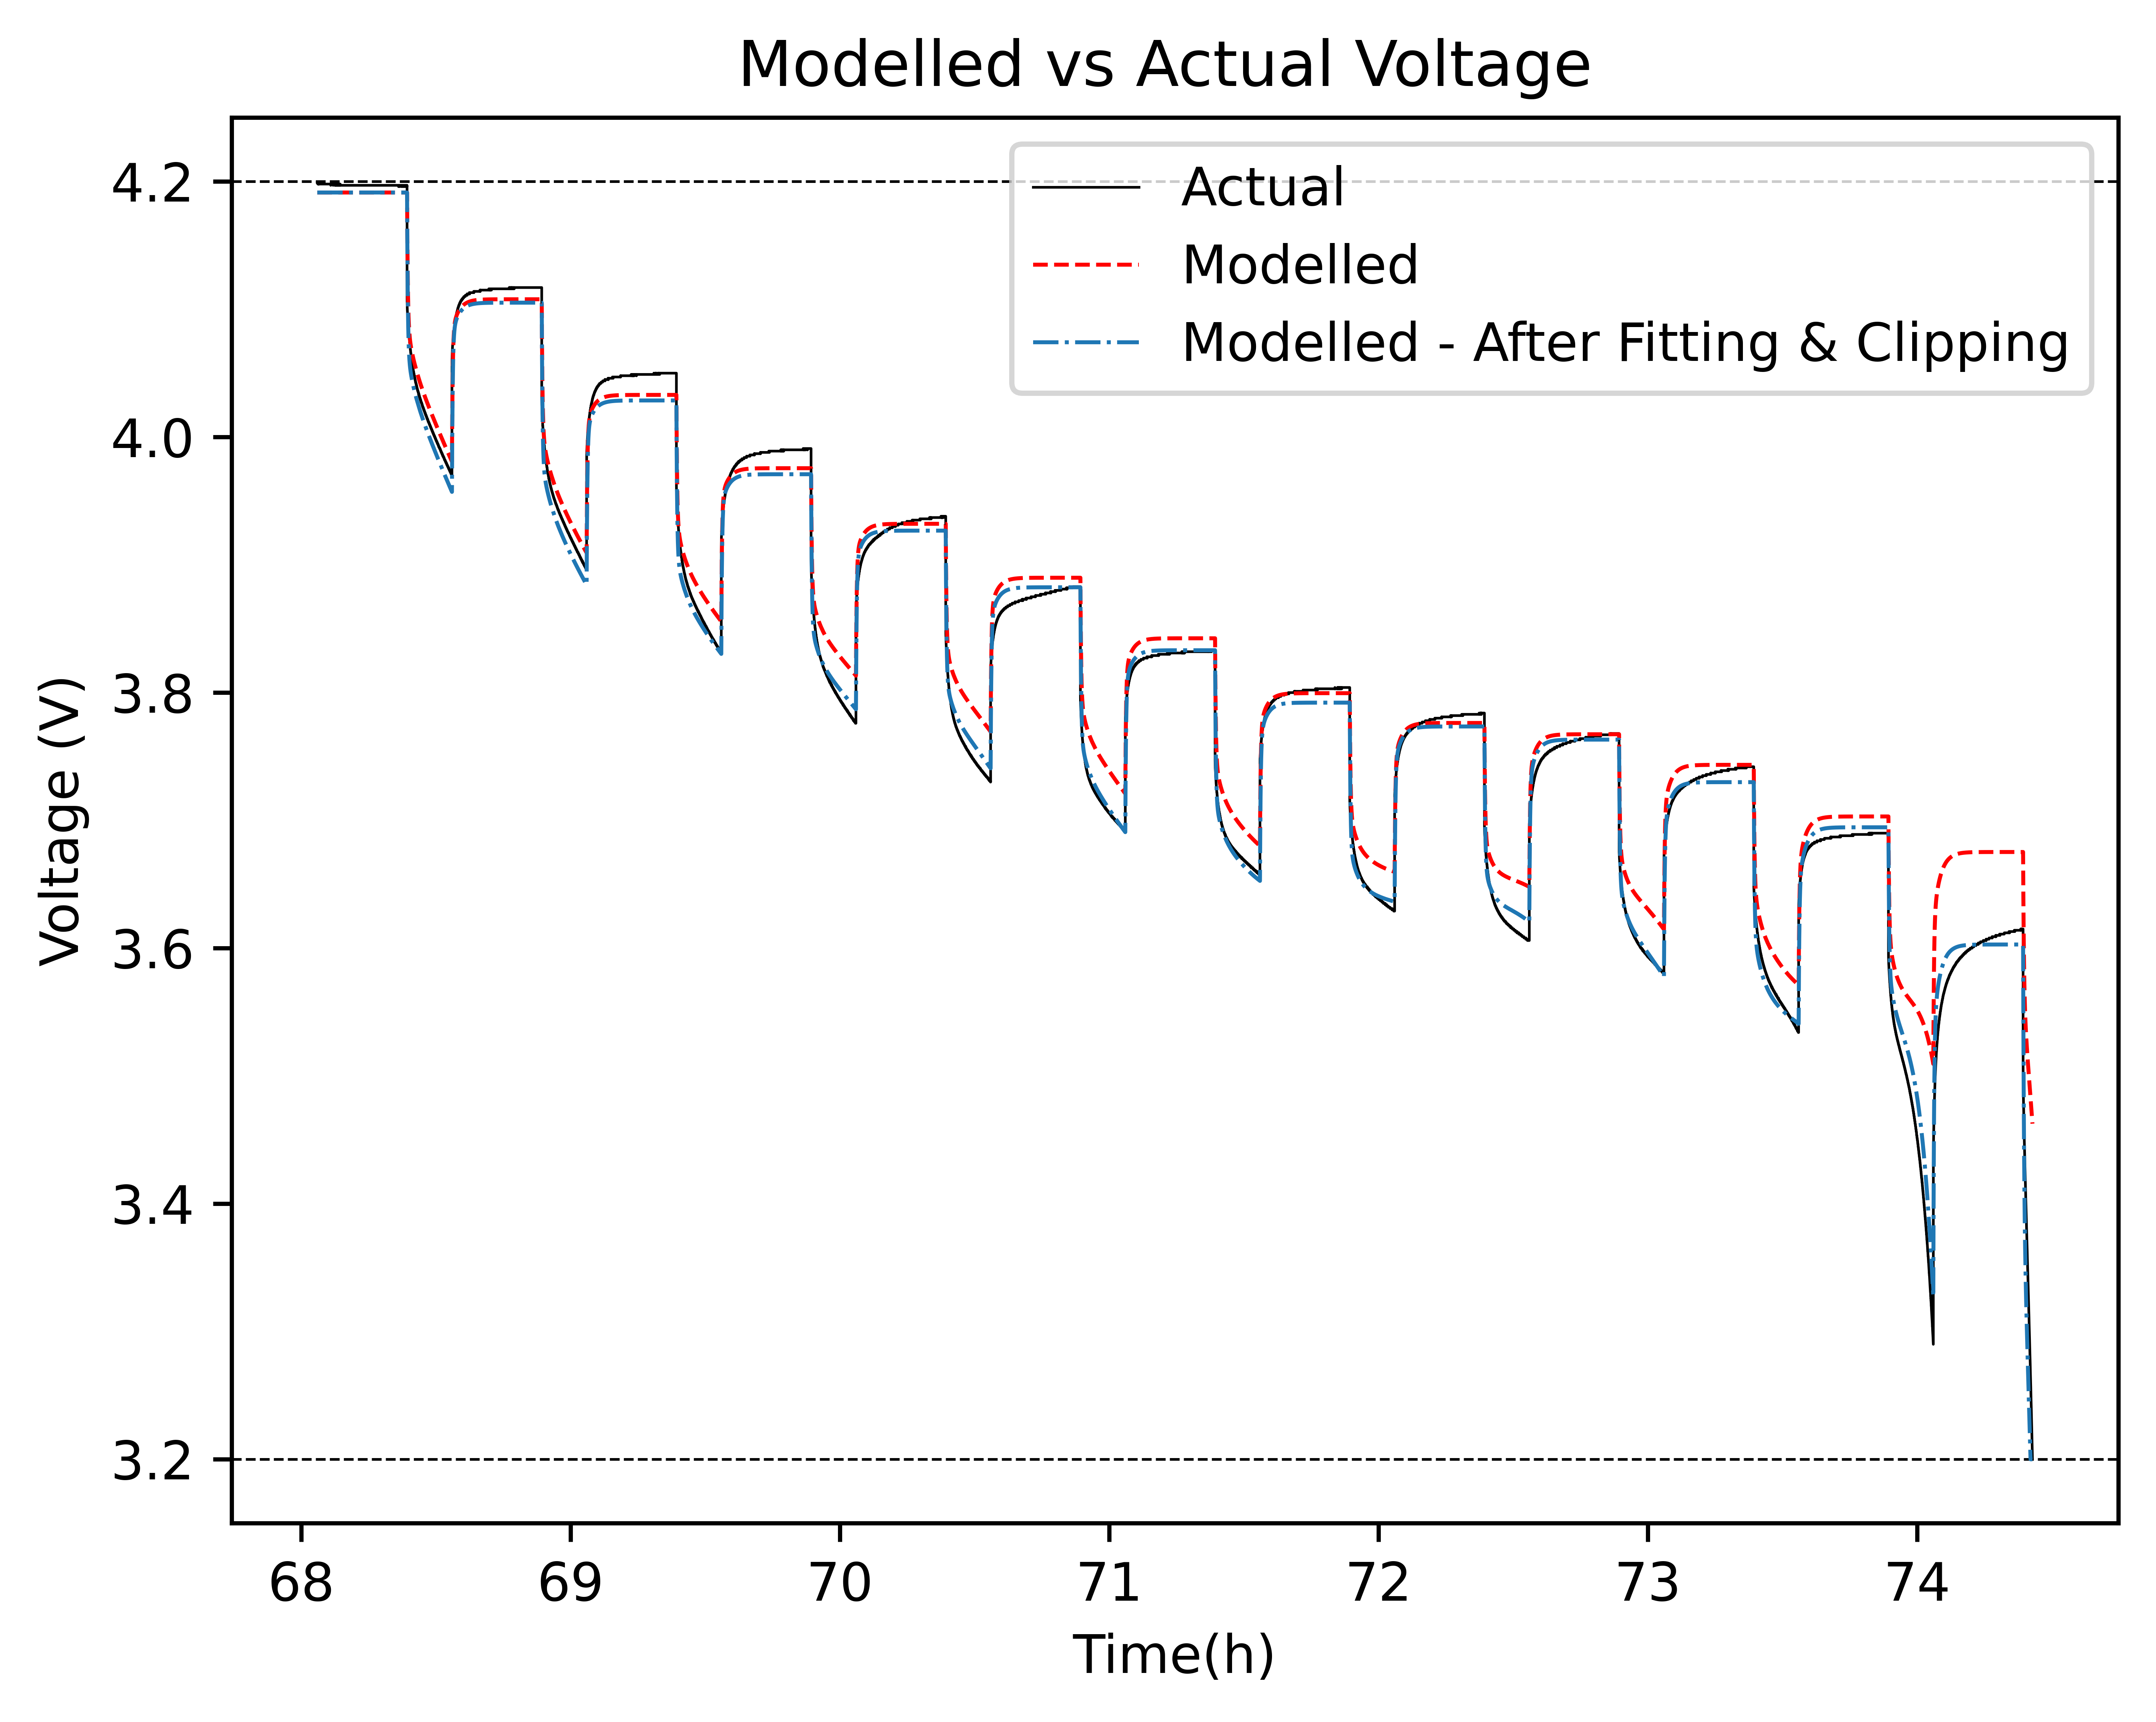

In [12]:
#Optimised, Unoptimised and Actual Voltage Plots
plt.figure()
plt.axhline(y=4.2, color='k', linestyle='--', linewidth = 0.5) # Upper Bound of Voltage = 4.2 V (100% SOC)
plt.axhline(y=3.2, color='k', linestyle='--', linewidth = 0.5) # Lower Bound of Voltage = 3.2 V 
plt.plot(df1.time[start:end+1]/3600,df1.voltage[start:end+1],'-k',label = "Actual",linewidth=0.5) # Dataset's Voltage (vs Time)
plt.plot(df1.time[start:end+1]/3600,Modelled,'-r',label = "Modelled",linewidth=0.75,linestyle='--') # Modelled Voltage (vs Time)
plt.plot(df1.time[start:end+1]/3600,Fitted,label = "Modelled - After Fitting & Clipping",linewidth=0.75,linestyle='-.')#, color = "green") # Fitted Voltage (vs Time)
plt.ylabel('Voltage (V)')
plt.xlabel('Time(h)')
plt.title('Modelled vs Actual Voltage ')
plt.legend(loc="upper right", prop={'size': 10})
plt.show()